In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import umap

from pantypeclustering.config import get_training_parameters
from pantypeclustering.dataloader import get_mnist_dataloaders
from pantypeclustering.model import GMVAE


/zhome/51/4/167677/Desktop/pantypeClustering/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cfg = get_training_parameters()

device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if hasattr(torch.backends, "mps") and torch.backends.mps.is_available()
    else "cpu"
)

model = GMVAE(
    y_size=cfg.y_size,
    x_size=cfg.x_size,
    w_size=cfg.w_size,
    hidden_size=cfg.hidden_size,
    number_of_mixtures=cfg.number_of_mixtures,
    mc=cfg.mc,
    continuous=cfg.continuous,
    lambda_threshold=cfg.lambda_threshold,
)

model.load_state_dict(torch.load('gmvae_mnist.pth', map_location="cpu"))
model.eval()

train_loader, test_loader = get_mnist_dataloaders(batch_size=256)

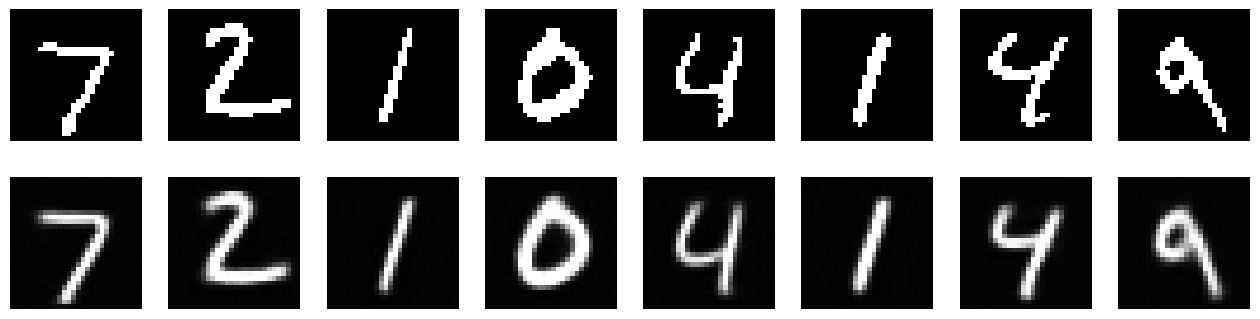

In [3]:
# Reconstruction on test set
def plot_reconstructions(model, data_loader, n=8) -> None:
    model.eval()
    with torch.no_grad():
        data_iter = iter(data_loader)
        images, _ = next(data_iter)
        recon_images = model.reconstruct(images)

    fig, axes = plt.subplots(2, n, figsize=(n * 2, 4))
    for i in range(n):
        axes[0, i].imshow(images[i].squeeze(), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(recon_images[i].squeeze(), cmap='gray')
        axes[1, i].axis('off')

    # Add anotation for original and reconstructed
    axes[0, 0].set_ylabel('Original', fontsize=14)
    axes[1, 0].set_ylabel('Reconstructed', fontsize=14)
    plt.show()

plot_reconstructions(model, test_loader, n=8)

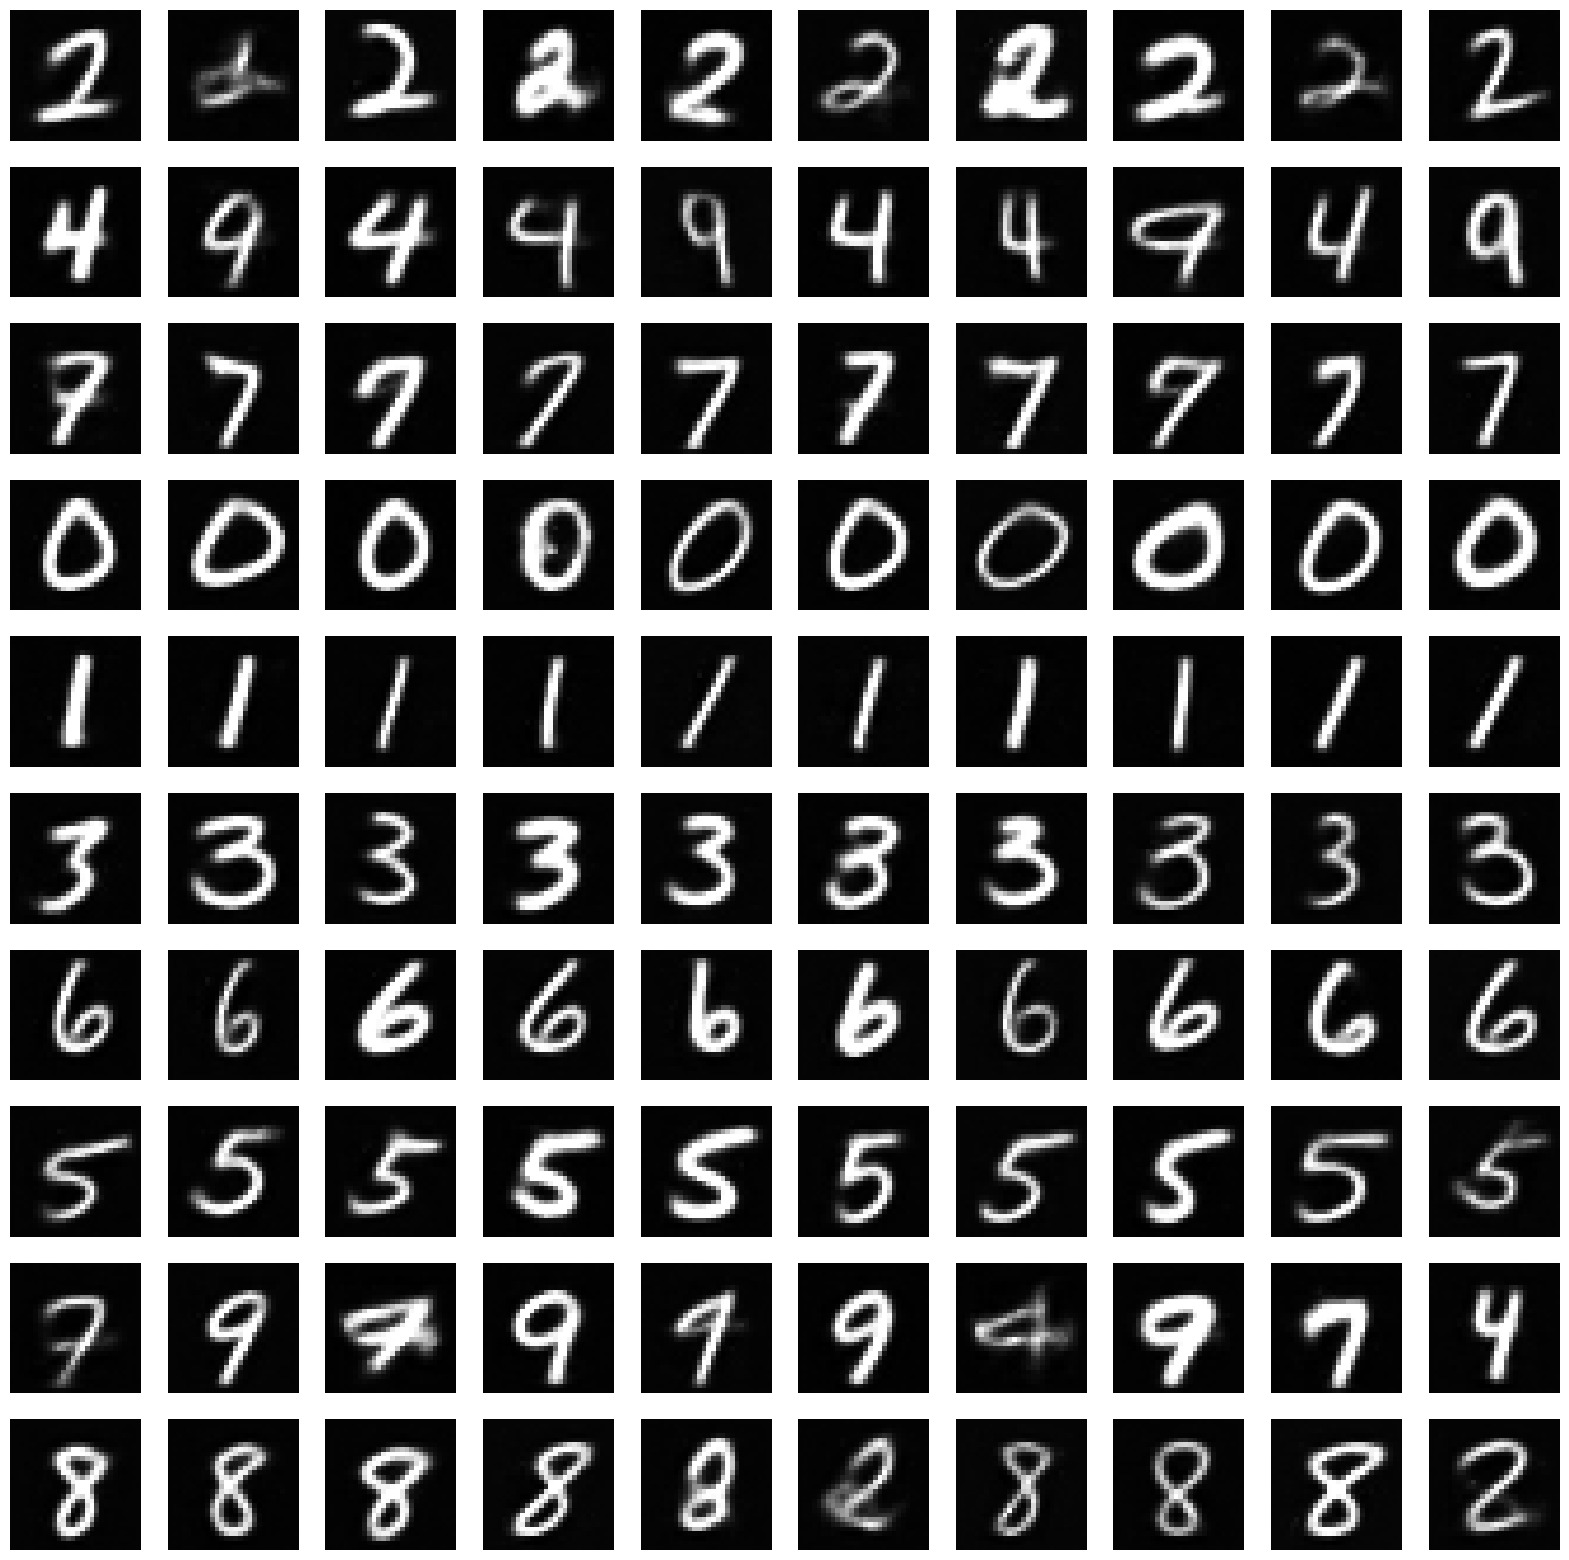

In [4]:

# Sample 10 images from each mixture component
def plot_samples_per_component(model, n_per_component=10):
    model.eval()
    with torch.no_grad():
        w = torch.zeros(150)
        (means, logvars) = model.priorgenerator(w.unsqueeze(0))


        fig, axes = plt.subplots(10, n_per_component, figsize=(n_per_component * 2, 2 * 10))
        for k in range(10):
            x_mu_k = means[k]
            x_sigma_k = torch.exp(0.5 * logvars[k])
            x_k_dist = torch.distributions.Normal(x_mu_k, x_sigma_k)
            x_samples = x_k_dist.sample((n_per_component,))
            y_samples_dist = model.ygenerator(x_samples.squeeze())
            for i in range(n_per_component):
                y_sample = y_samples_dist[i]
                axes[k, i].imshow(y_sample.squeeze(), cmap='gray')
                axes[k, i].axis('off')
            axes[k, 0].set_ylabel(f'Comp {k}', fontsize=12)
        plt.show()


plot_samples_per_component(model, n_per_component=10)

In [5]:
reducer = clusterable_embedding = umap.UMAP(
    n_neighbors=10,
    min_dist=0.5,
    n_components=2,
    random_state=42,
)

latent_representations = []
labels_list = []
model.eval()
with torch.no_grad():

    for images, labels in train_loader:
        (mean_x, logvar_x), (mean_w, logvar_w) = model.recogniser(images)
        latent_representations.append(mean_x)
        labels_list.append(labels)

latent_representations = torch.cat(latent_representations, dim=0).cpu().numpy()
labels = torch.cat(labels_list, dim=0).cpu().numpy()

# Fit UMAP
umap_model = reducer.fit(latent_representations)
embedding = umap_model.transform(latent_representations)



/zhome/51/4/167677/Desktop/pantypeClustering/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [6]:
from sklearn.decomposition import PCA

In [8]:
reducer = PCA(n_components=2)

latent_representations = []
labels_list = []
model.eval()
with torch.no_grad():

    for images, labels in train_loader:
        (mean_x, logvar_x), (mean_w, logvar_w) = model.recogniser(images)
        latent_representations.append(mean_x)
        labels_list.append(labels)

latent_representations = torch.cat(latent_representations, dim=0).cpu().numpy()
labels = torch.cat(labels_list, dim=0).cpu().numpy()

# Fit PCA
pca_model = reducer.fit(latent_representations)
embedding = pca_model.transform(latent_representations)



/tmp/ipykernel_398273/4100580967.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=x_embedding[:, 0], y=x_embedding[:, 1],palette="tab10", marker='X', s=100, legend='full')


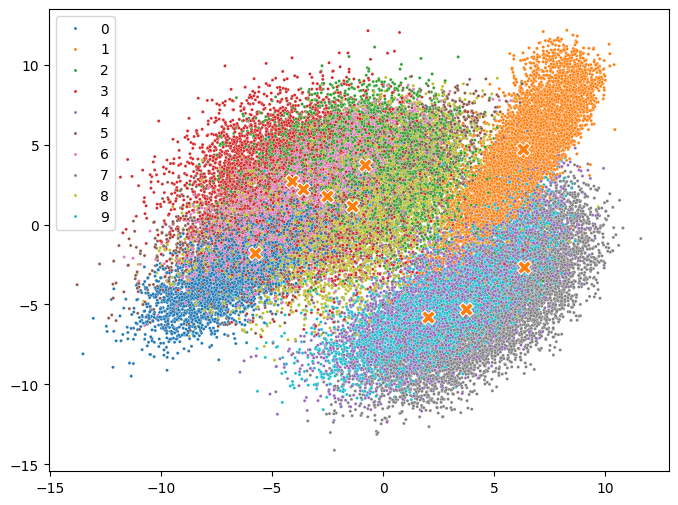

In [9]:
    # Plot UMAP
plt.figure(figsize=(8, 6))
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=labels, palette="tab10",legend="full", s=5)

model.eval()
with torch.no_grad():
    w_means = torch.zeros(150)
    (means, logvars) = model.priorgenerator(w_means.reshape(1, -1))

    means = torch.stack(means).squeeze()

    x_mixture_means = means.cpu().numpy().squeeze()  # Shape: (K, dim_x)

x_embedding = umap_model.transform(x_mixture_means)
sns.scatterplot(x=x_embedding[:, 0], y=x_embedding[:, 1],palette="tab10", marker='X', s=100, legend='full')

plt.show()

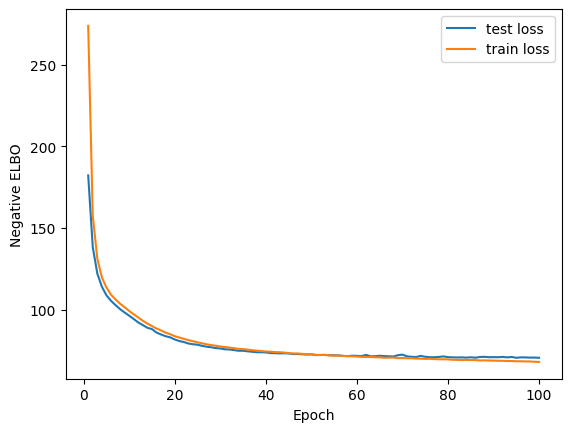

In [7]:

test_loss = torch.load('avg_test.npy')
train_loss = torch.load('avg_train.npy')

epochs = range(1,101)

plt.plot(epochs, test_loss, label='test loss')
plt.plot(epochs,train_loss, label='train loss')
plt.xlabel('Epoch')
plt.ylabel('Negative ELBO')
plt.legend()


In [1]:
import torch
import pandas as pd

seeds = [10, 12, 13, 15, 20, 22, 25, 30, 50, 80]

accuracies = torch.hstack([torch.load(f"accuracy{i}.npy") for i in seeds])
accuracies.shape

df = pd.DataFrame({
    "epoch": torch.arange(1, 101).repeat(10),
    "accuracies": accuracies,
})

<Axes: xlabel='epoch', ylabel='accuracies'>

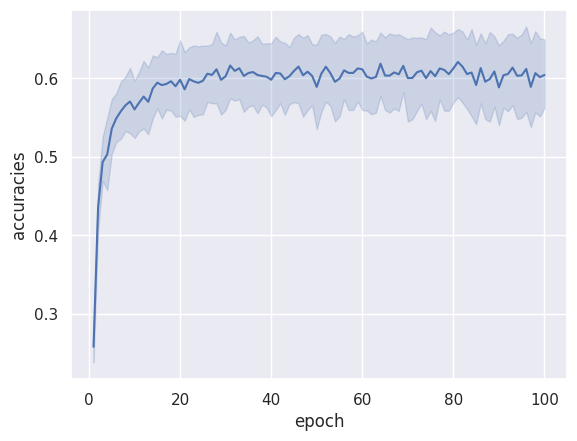

In [2]:
import seaborn as sns
sns.set_theme(style="darkgrid")

sns.lineplot(df, x='epoch', y='accuracies')


Text(0.5, 1.0, 'Accuracy over 5 runs')

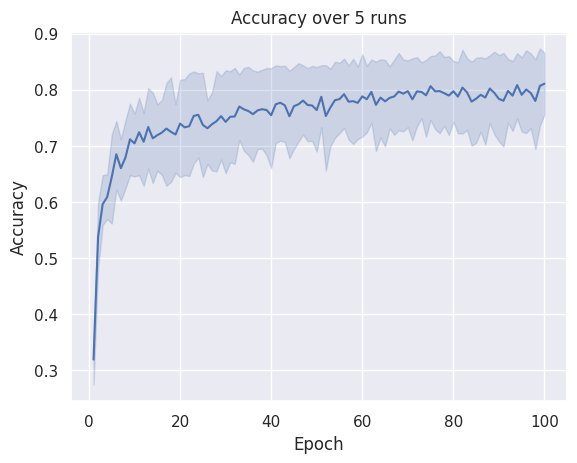

In [8]:
import torch
import pandas as pd
import matplotlib.pyplot as plt

seeds = [10,11,12, 13, 14]

accuracies = torch.hstack([torch.load(f"accuracy_{i}.npy") for i in seeds])
accuracies.shape

df = pd.DataFrame({
    "Epoch": torch.arange(1, 101).repeat(len(seeds)),
    "Accuracy": accuracies,
})
import seaborn as sns
sns.set_theme(style="darkgrid")

sns.lineplot(df, x='Epoch', y='Accuracy')
plt.title(f"Accuracy over 5 runs")